In [1]:
import json
import random
import hashlib
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import (
    AutoTokenizer,
    T5ForConditionalGeneration,
    get_cosine_schedule_with_warmup
)
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import random

In [2]:
class Config:
    train_path = "./data/DuReaderQG/train.json"
    valid_path = "./data/DuReaderQG/dev.json"
    # model_path = "./model"
    save_dir = "./best_models"
    max_source_length = 1024
    max_target_length = 128
    batch_size = 4
    accum_steps = 4
    epochs = 30
    val_samples_per_epoch = 1
    seed = 42
    valid_shuffle = True  

In [3]:
# 初始化设置
torch.manual_seed(Config.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ================== 数据加载 ==================
def load_train_data(path):
    """加载训练数据（保持原始格式）"""
    with open(path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f if line.strip()]

def load_valid_data(path):
    """加载验证数据（合并相同context+question）"""
    grouped = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                sample = json.loads(line)
                key = hashlib.md5(
                    (sample["context"] + sample["question"]).encode()
                ).hexdigest()
                if key not in grouped:
                    grouped[key] = {
                        "context": sample["context"],
                        "question": sample["question"],
                        "answers": [],
                        "ids": []
                    }
                grouped[key]["answers"].append(sample["answer"])
                grouped[key]["ids"].append(sample["id"])
    return list(grouped.values())

# 数据检查点
print("\n=== 数据加载检查 ===")
train_data = load_train_data(Config.train_path)
valid_data = load_valid_data(Config.valid_path)
print(f"训练集样本数: {len(train_data)}")
print(f"验证集样本数: {len(valid_data)} (合并后)")

Using device: cuda

=== 数据加载检查 ===
训练集样本数: 14520
验证集样本数: 700 (合并后)


In [4]:
train_data[0]

{'context': '第35集雪见缓缓张开眼睛，景天又惊又喜之际，长卿和紫萱的仙船驶至，见众人无恙，也十分高兴。众人登船，用尽合力把自身的真气和水分输给她。雪见终于醒过来了，但却一脸木然，全无反应。众人向常胤求助，却发现人世界竟没有雪见的身世纪录。长卿询问清微的身世，清微语带双关说一切上了天界便有答案。长卿驾驶仙船，众人决定立马动身，往天界而去。众人来到一荒山，长卿指出，魔界和天界相连。由魔界进入通过神魔之井，便可登天。众人至魔界入口，仿若一黑色的蝙蝠洞，但始终无法进入。后来花楹发现只要有翅膀便能飞入。于是景天等人打下许多乌鸦，模仿重楼的翅膀，制作数对翅膀状巨物。刚佩戴在身，便被吸入洞口。众人摔落在地，抬头发现魔界守卫。景天和众魔套交情，自称和魔尊重楼相熟，众魔不理，打了起来。',
 'answer': '第35集',
 'question': '仙剑奇侠传3第几集上天界',
 'id': 0}

In [15]:
valid_data[0]

{'context': '年基准利率4.35%。 从实际看,贷款的基本条件是: 一是中国大陆居民,年龄在60岁以下; 二是有稳定的住址和工作或经营地点; 三是有稳定的收入来源; 四是无不良信用记录,贷款用途不能作为炒股,赌博等行为; 五是具有完全民事行为能力。',
 'question': '2017年银行贷款基准利率',
 'answers': ['年基准利率4.35%', '4.35%'],
 'ids': [0, 1]}

In [ ]:
class QADataset(Dataset):
    def __init__(self, data, is_train=True):
        self.data = data
        self.is_train = is_train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        if self.is_train:
            return {
                "context": item["context"],
                "question": item["question"],
                "answer": item["answer"],
                "id": item["id"]
            }
        else:
            return {
                "context": item["context"],
                "question": item["question"],
                "answers": item["answers"],
                "id": item["ids"][0]
            }

train_dataset = QADataset(train_data, is_train=True)
valid_dataset = QADataset(valid_data, is_train=False)

In [16]:
train_dataset[0]

{'context': '第35集雪见缓缓张开眼睛，景天又惊又喜之际，长卿和紫萱的仙船驶至，见众人无恙，也十分高兴。众人登船，用尽合力把自身的真气和水分输给她。雪见终于醒过来了，但却一脸木然，全无反应。众人向常胤求助，却发现人世界竟没有雪见的身世纪录。长卿询问清微的身世，清微语带双关说一切上了天界便有答案。长卿驾驶仙船，众人决定立马动身，往天界而去。众人来到一荒山，长卿指出，魔界和天界相连。由魔界进入通过神魔之井，便可登天。众人至魔界入口，仿若一黑色的蝙蝠洞，但始终无法进入。后来花楹发现只要有翅膀便能飞入。于是景天等人打下许多乌鸦，模仿重楼的翅膀，制作数对翅膀状巨物。刚佩戴在身，便被吸入洞口。众人摔落在地，抬头发现魔界守卫。景天和众魔套交情，自称和魔尊重楼相熟，众魔不理，打了起来。',
 'question': '仙剑奇侠传3第几集上天界',
 'answer': '第35集',
 'id': 0}

In [17]:
valid_dataset[0]

{'context': '年基准利率4.35%。 从实际看,贷款的基本条件是: 一是中国大陆居民,年龄在60岁以下; 二是有稳定的住址和工作或经营地点; 三是有稳定的收入来源; 四是无不良信用记录,贷款用途不能作为炒股,赌博等行为; 五是具有完全民事行为能力。',
 'question': '2017年银行贷款基准利率',
 'answers': ['年基准利率4.35%', '4.35%'],
 'id': 0}

In [ ]:
class ValidChunker:
    def __init__(self, dataset, total_epochs):
        self.dataset = dataset
        self.total_samples = len(dataset)
        self.total_epochs = total_epochs
        self.samples_per_epoch = self.total_samples // self.total_epochs
        
        self.indices = torch.arange(self.total_samples).tolist()
        if Config.valid_shuffle:
            random.shuffle(self.indices)
        
        # 处理不能整除的情况
        if self.total_samples % self.total_epochs != 0:
            pad = self.total_epochs - (self.total_samples % self.total_epochs)
            self.indices += self.indices[:pad]
            self.total_samples += pad

    def get_chunk_indices(self, epoch):
        start = epoch * self.samples_per_epoch
        end = start + self.samples_per_epoch
        return self.indices[start:end]

valid_chunker = ValidChunker(valid_dataset, Config.epochs)

tokenizer = AutoTokenizer.from_pretrained(Config.model_path)

def train_collate(batch):
    inputs = [f"question: {x['question']} context: {x['context']}" for x in batch]
    targets = [x["answer"] for x in batch]

    source = tokenizer(
        inputs,
        max_length=Config.max_source_length,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )
    targets = tokenizer(
        targets,
        max_length=Config.max_target_length,
        truncation=True,
        padding=True,
        return_tensors="pt"
    ).input_ids

    targets[targets == tokenizer.pad_token_id] = -100
    return {
        "input_ids": source.input_ids,
        "attention_mask": source.attention_mask,
        "labels": targets
    }

def valid_collate(batch):
    inputs = [f"question: {x['question']} context: {x['context']}" for x in batch]
    processed = tokenizer(
        inputs,
        max_length=Config.max_source_length,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )
    return {
        "input_ids": processed.input_ids,
        "attention_mask": processed.attention_mask,
        "contexts": [x["context"] for x in batch],
        "questions": [x["question"] for x in batch],
        "answers": [x["answers"] for x in batch],
        "ids": [x["id"] for x in batch]
    }

model = T5ForConditionalGeneration.from_pretrained(Config.model_path).to(device)

optimizer = AdamW(model.parameters(), lr=1e-4)
train_loader = DataLoader(
    train_dataset,
    batch_size=Config.batch_size,
    shuffle=True,
    collate_fn=train_collate
)

num_training_steps = len(train_loader) * Config.epochs // Config.accum_steps
num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup，可调

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)


class BleuEvaluator:
    def __init__(self):
        self.smooth = SmoothingFunction().method1
        self.weights = {
            1: (1, 0, 0, 0),
            2: (0.5, 0.5, 0, 0),
            3: (1/3, 1/3, 1/3, 0),
            4: (0.25, 0.25, 0.25, 0.25)
        }

    def calc_bleu(self, pred, refs):
        pred_tokens = list(pred.strip())
        ref_tokens = [list(r.strip()) for r in refs]
        return {
            f"BLEU-{n}": sentence_bleu(
                ref_tokens, pred_tokens,
                weights=self.weights[n],
                smoothing_function=self.smooth
            ) for n in range(1, 5)
        }

    @staticmethod
    def dynamic_score(scores, pred_len):
        if pred_len <= 2:
            return scores["BLEU-1"] * 0.6 + scores["BLEU-2"] * 0.4
        elif 3 <= pred_len <= 5:
            return scores["BLEU-2"] * 0.5 + scores["BLEU-3"] * 0.3 + scores["BLEU-4"] * 0.2
        else:
            return scores["BLEU-4"] * 0.7 + scores["BLEU-3"] * 0.3

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/root/miniconda3/lib/python3.12/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# 假设你已经定义好 train_dataloader
batch = next(iter(train_loader))  # train_loader 就是你的 DataLoader 对象

# 将张量移动到 CPU，便于查看
for key, value in batch.items():
    print(f"{key}:")
    print(value if isinstance(value, list) else value.shape)
    print("-" * 50)

input_ids:
torch.Size([4, 198])
--------------------------------------------------
attention_mask:
torch.Size([4, 198])
--------------------------------------------------
labels:
torch.Size([4, 5])
--------------------------------------------------


In [19]:
print("input_ids 示例:")
print(batch["input_ids"][0])  # 第一个样本的 token id 序列
print("解码为文本:")
print(tokenizer.decode(batch["input_ids"][0], skip_special_tokens=True))

print("\nlabels 示例:")
print(batch["labels"][0])
print("解码为文本:")
label_ids = batch["labels"][0]
# 替换掉 -100（忽略值）为 pad_token_id，再解码
label_ids = [id if id != -100 else tokenizer.pad_token_id for id in label_ids]
print(tokenizer.decode(label_ids, skip_special_tokens=True))

input_ids 示例:
tensor([ 3454,  2055, 21293, 15807,    13,     7,  2319,   219, 13176,  6784,
         1529,  1112,   217, 13488,     7, 25395,  7368,  1733,  1550,    13,
            7,     8,  4866, 22397,  7774,   744,   806, 11583,  2382,     3,
         4801,    34,  4866,    10, 22397,  7774,     7,  1977,  1279,     5,
        13488,     3,   710,    23,  4951,  2319,   219, 12598,  6784,  2092,
         1112,  6991, 16987, 13488,   190,  2319,   219, 12598,  6784,  2092,
         1112,   920,  5425,     5,  1931, 19210,  1131,     3,    62,  4951,
         2379,  1931,  2007,  2319,   219, 13357,  6784,  2092,  1112,  6991,
           99,  2263, 13488,     6,  2319,   219, 13357,  6784,  1112,   920,
        10297, 13488,     4,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [4]:

best_dynamic = 0.0
loss_history = []
lr_history = []
bleu1_history = []
bleu2_history = []
bleu3_history = []
bleu4_history = []
dynamic_history = []

def validate(loader):
    evaluator = BleuEvaluator()
    all_bleu = []
    all_dynamic = []
    displayed = set()
    
    for batch in loader:
        inputs = batch["input_ids"].to(device)
        generated = model.generate(
            inputs,
            max_length=Config.max_target_length,
            num_beams=5,
            early_stopping=True
        )
        preds = tokenizer.batch_decode(generated, skip_special_tokens=True)
        
        for i, (pred, refs) in enumerate(zip(preds, batch["answers"])):
            bleu = evaluator.calc_bleu(pred, refs)
            all_bleu.append(bleu)
            
            pred_len = len(list(pred.strip()))
            dynamic = BleuEvaluator.dynamic_score(bleu, pred_len)
            all_dynamic.append(dynamic)
    
    avg_bleu = {
        f"BLEU-{n}": np.mean([b[f"BLEU-{n}"] for b in all_bleu]) * 100
        for n in range(1, 5)
    }
    avg_dynamic = np.mean(all_dynamic) * 100
    return avg_bleu, avg_dynamic

def save_model(epoch, dynamic_score):
    save_path = Path(Config.save_dir) / f"epoch_{epoch}_dynamic_{dynamic_score:.2f}"
    save_path.mkdir(parents=True, exist_ok=True)
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"\n模型保存至: {save_path}")


In [5]:
for epoch in range(Config.epochs):
    model.train()
    epoch_loss = 0.0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.epochs} [Train]")
    
    for step, batch in enumerate(progress):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss / Config.accum_steps
        loss.backward()
        
        if (step+1) % Config.accum_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        epoch_loss += loss.item() * Config.accum_steps
        current_lr = scheduler.get_last_lr()[0]
        progress.set_postfix({"loss": f"{loss.item():.4f}", "lr": f"{current_lr:.2e}"})
        
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    lr_history.append(current_lr)
    
    chunk_loader = DataLoader(
        valid_dataset,  # ← 直接用整个验证集
        batch_size=Config.batch_size,
        collate_fn=valid_collate
    )

    #print(f"\n[Epoch {epoch+1} 验证进度] 正在验证 {len(chunk_subset)} 个样本")
    chunk_bleu, dynamic_score = validate(chunk_loader)

# 拆分各 BLEU 分数
    bleu1_history.append(chunk_bleu["BLEU-1"])
    bleu2_history.append(chunk_bleu["BLEU-2"])
    bleu3_history.append(chunk_bleu["BLEU-3"])
    bleu4_history.append(chunk_bleu["BLEU-4"])
    dynamic_history.append(dynamic_score)

    print(f"Epoch {epoch+1} 验证结果：BLEU-1: {chunk_bleu['BLEU-1']:.2f}%, "
      f"BLEU-2: {chunk_bleu['BLEU-2']:.2f}%, "
      f"BLEU-3: {chunk_bleu['BLEU-3']:.2f}%, "
      f"BLEU-4: {chunk_bleu['BLEU-4']:.2f}%, "
      f"动态得分: {dynamic_score:.2f}%")

    if dynamic_score > best_dynamic:
        best_dynamic = dynamic_score
        save_model(epoch+1, dynamic_score)
    
    if (epoch+1) % 5 == 0 or epoch == Config.epochs-1:
        full_loader = DataLoader(
            valid_dataset,
            batch_size=Config.batch_size,
            collate_fn=valid_collate
        )

        full_bleu , full_avg_dynamic = validate(full_loader)
        print(f"\n[完整验证] BLEU-4: {full_bleu['BLEU-4']:.2f}% | 动态得分: {full_avg_dynamic:.2f}%")

Epoch 1/30 [Train]: 100%|██████████| 3630/3630 [07:27<00:00,  8.12it/s, loss=0.1497, lr=3.33e-05]


Epoch 1 验证结果：BLEU-1: 72.37%, BLEU-2: 69.97%, BLEU-3: 62.75%, BLEU-4: 56.57%, 动态得分: 67.88%

模型保存至: best_models/epoch_1_dynamic_67.88


Epoch 2/30 [Train]: 100%|██████████| 3630/3630 [07:28<00:00,  8.09it/s, loss=0.1007, lr=6.66e-05]


Epoch 2 验证结果：BLEU-1: 77.61%, BLEU-2: 75.19%, BLEU-3: 68.09%, BLEU-4: 61.99%, 动态得分: 73.20%

模型保存至: best_models/epoch_2_dynamic_73.20


Epoch 3/30 [Train]: 100%|██████████| 3630/3630 [07:28<00:00,  8.09it/s, loss=0.1856, lr=1.00e-04]


Epoch 3 验证结果：BLEU-1: 74.45%, BLEU-2: 71.96%, BLEU-3: 64.85%, BLEU-4: 58.66%, 动态得分: 69.79%


Epoch 4/30 [Train]: 100%|██████████| 3630/3630 [07:26<00:00,  8.13it/s, loss=0.0789, lr=9.97e-05]


Epoch 4 验证结果：BLEU-1: 73.88%, BLEU-2: 71.52%, BLEU-3: 64.64%, BLEU-4: 58.11%, 动态得分: 69.55%


Epoch 5/30 [Train]: 100%|██████████| 3630/3630 [07:25<00:00,  8.14it/s, loss=0.0147, lr=9.87e-05]


Epoch 5 验证结果：BLEU-1: 75.13%, BLEU-2: 72.93%, BLEU-3: 65.27%, BLEU-4: 58.83%, 动态得分: 71.07%

[完整验证] BLEU-4: 57.17% | 动态得分: 68.98%


Epoch 6/30 [Train]: 100%|██████████| 3630/3630 [07:27<00:00,  8.11it/s, loss=0.0805, lr=9.70e-05]


Epoch 6 验证结果：BLEU-1: 75.43%, BLEU-2: 73.20%, BLEU-3: 65.77%, BLEU-4: 59.59%, 动态得分: 71.45%


Epoch 7/30 [Train]: 100%|██████████| 3630/3630 [07:27<00:00,  8.11it/s, loss=0.0176, lr=9.47e-05]


Epoch 7 验证结果：BLEU-1: 75.22%, BLEU-2: 72.71%, BLEU-3: 65.09%, BLEU-4: 58.78%, 动态得分: 70.87%


Epoch 8/30 [Train]: 100%|██████████| 3630/3630 [07:27<00:00,  8.11it/s, loss=0.0208, lr=9.18e-05]


Epoch 8 验证结果：BLEU-1: 75.23%, BLEU-2: 73.17%, BLEU-3: 65.62%, BLEU-4: 59.27%, 动态得分: 71.07%


Epoch 9/30 [Train]: 100%|██████████| 3630/3630 [07:28<00:00,  8.09it/s, loss=0.2065, lr=8.83e-05]


Epoch 9 验证结果：BLEU-1: 75.02%, BLEU-2: 72.74%, BLEU-3: 65.48%, BLEU-4: 59.50%, 动态得分: 70.51%


Epoch 10/30 [Train]: 100%|██████████| 3630/3630 [07:27<00:00,  8.11it/s, loss=0.0626, lr=8.43e-05]


Epoch 10 验证结果：BLEU-1: 75.78%, BLEU-2: 73.17%, BLEU-3: 65.96%, BLEU-4: 59.93%, 动态得分: 71.44%

[完整验证] BLEU-4: 59.46% | 动态得分: 71.16%


Epoch 11/30 [Train]: 100%|██████████| 3630/3630 [07:27<00:00,  8.11it/s, loss=0.1017, lr=7.99e-05]


Epoch 11 验证结果：BLEU-1: 76.41%, BLEU-2: 74.02%, BLEU-3: 67.01%, BLEU-4: 60.86%, 动态得分: 72.27%


Epoch 12/30 [Train]: 100%|██████████| 3630/3630 [07:23<00:00,  8.18it/s, loss=0.0135, lr=7.50e-05]


Epoch 12 验证结果：BLEU-1: 76.58%, BLEU-2: 74.23%, BLEU-3: 66.89%, BLEU-4: 60.73%, 动态得分: 72.36%


Epoch 13/30 [Train]: 100%|██████████| 3630/3630 [07:28<00:00,  8.10it/s, loss=0.0007, lr=6.98e-05]


Epoch 13 验证结果：BLEU-1: 76.46%, BLEU-2: 74.00%, BLEU-3: 66.99%, BLEU-4: 60.57%, 动态得分: 72.36%


Epoch 14/30 [Train]: 100%|██████████| 3630/3630 [07:28<00:00,  8.10it/s, loss=0.0112, lr=6.44e-05]


Epoch 14 验证结果：BLEU-1: 77.39%, BLEU-2: 75.09%, BLEU-3: 67.94%, BLEU-4: 61.56%, 动态得分: 73.21%

模型保存至: best_models/epoch_14_dynamic_73.21


Epoch 15/30 [Train]: 100%|██████████| 3630/3630 [07:28<00:00,  8.09it/s, loss=0.1019, lr=5.87e-05]


Epoch 15 验证结果：BLEU-1: 77.06%, BLEU-2: 74.71%, BLEU-3: 67.42%, BLEU-4: 61.48%, 动态得分: 72.77%

[完整验证] BLEU-4: 60.75% | 动态得分: 71.58%


Epoch 16/30 [Train]: 100%|██████████| 3630/3630 [07:28<00:00,  8.09it/s, loss=0.0003, lr=5.30e-05]


Epoch 16 验证结果：BLEU-1: 77.08%, BLEU-2: 74.77%, BLEU-3: 67.48%, BLEU-4: 61.58%, 动态得分: 72.85%


Epoch 17/30 [Train]: 100%|██████████| 3630/3630 [07:28<00:00,  8.09it/s, loss=0.0001, lr=4.71e-05]


Epoch 17 验证结果：BLEU-1: 76.53%, BLEU-2: 74.31%, BLEU-3: 66.74%, BLEU-4: 60.55%, 动态得分: 72.36%


Epoch 18/30 [Train]: 100%|██████████| 3630/3630 [07:28<00:00,  8.09it/s, loss=0.1537, lr=4.14e-05]


Epoch 18 验证结果：BLEU-1: 77.31%, BLEU-2: 75.04%, BLEU-3: 67.87%, BLEU-4: 61.64%, 动态得分: 73.46%

模型保存至: best_models/epoch_18_dynamic_73.46


Epoch 19/30 [Train]: 100%|██████████| 3630/3630 [07:27<00:00,  8.11it/s, loss=0.0002, lr=3.57e-05]


Epoch 19 验证结果：BLEU-1: 77.54%, BLEU-2: 75.52%, BLEU-3: 68.71%, BLEU-4: 62.65%, 动态得分: 73.92%

模型保存至: best_models/epoch_19_dynamic_73.92


Epoch 20/30 [Train]: 100%|██████████| 3630/3630 [07:28<00:00,  8.09it/s, loss=0.0001, lr=3.03e-05]


Epoch 20 验证结果：BLEU-1: 78.88%, BLEU-2: 76.69%, BLEU-3: 69.27%, BLEU-4: 62.70%, 动态得分: 74.99%

模型保存至: best_models/epoch_20_dynamic_74.99

[完整验证] BLEU-4: 62.20% | 动态得分: 73.58%


Epoch 21/30 [Train]: 100%|██████████| 3630/3630 [07:27<00:00,  8.10it/s, loss=0.0001, lr=2.51e-05]


Epoch 21 验证结果：BLEU-1: 79.07%, BLEU-2: 76.84%, BLEU-3: 69.76%, BLEU-4: 63.48%, 动态得分: 75.21%

模型保存至: best_models/epoch_21_dynamic_75.21


Epoch 22/30 [Train]: 100%|██████████| 3630/3630 [07:28<00:00,  8.09it/s, loss=0.0001, lr=2.02e-05]


Epoch 22 验证结果：BLEU-1: 78.60%, BLEU-2: 76.50%, BLEU-3: 69.64%, BLEU-4: 63.35%, 动态得分: 74.87%


Epoch 23/30 [Train]: 100%|██████████| 3630/3630 [07:30<00:00,  8.06it/s, loss=0.0003, lr=1.57e-05]


Epoch 23 验证结果：BLEU-1: 78.48%, BLEU-2: 76.41%, BLEU-3: 69.18%, BLEU-4: 62.88%, 动态得分: 74.52%


Epoch 24/30 [Train]: 100%|██████████| 3630/3630 [07:31<00:00,  8.04it/s, loss=0.0007, lr=1.17e-05]


Epoch 24 验证结果：BLEU-1: 78.97%, BLEU-2: 76.92%, BLEU-3: 70.04%, BLEU-4: 63.87%, 动态得分: 75.24%

模型保存至: best_models/epoch_24_dynamic_75.24


Epoch 25/30 [Train]: 100%|██████████| 3630/3630 [07:30<00:00,  8.05it/s, loss=0.0001, lr=8.27e-06]


Epoch 25 验证结果：BLEU-1: 78.85%, BLEU-2: 76.69%, BLEU-3: 69.77%, BLEU-4: 63.36%, 动态得分: 74.97%

[完整验证] BLEU-4: 63.15% | 动态得分: 75.02%


Epoch 26/30 [Train]: 100%|██████████| 3630/3630 [07:29<00:00,  8.08it/s, loss=0.0000, lr=5.36e-06]


Epoch 26 验证结果：BLEU-1: 78.51%, BLEU-2: 76.50%, BLEU-3: 69.58%, BLEU-4: 63.34%, 动态得分: 74.74%


Epoch 27/30 [Train]: 100%|██████████| 3630/3630 [07:34<00:00,  7.99it/s, loss=0.0001, lr=3.04e-06]


Epoch 27 验证结果：BLEU-1: 78.91%, BLEU-2: 76.93%, BLEU-3: 69.85%, BLEU-4: 63.22%, 动态得分: 75.14%


Epoch 28/30 [Train]: 100%|██████████| 3630/3630 [07:31<00:00,  8.04it/s, loss=0.0001, lr=1.37e-06]


Epoch 28 验证结果：BLEU-1: 78.12%, BLEU-2: 75.83%, BLEU-3: 68.80%, BLEU-4: 62.71%, 动态得分: 74.03%


Epoch 29/30 [Train]: 100%|██████████| 3630/3630 [07:29<00:00,  8.07it/s, loss=0.0001, lr=3.49e-07]


Epoch 29 验证结果：BLEU-1: 78.45%, BLEU-2: 76.41%, BLEU-3: 69.50%, BLEU-4: 63.25%, 动态得分: 74.71%


Epoch 30/30 [Train]: 100%|██████████| 3630/3630 [07:28<00:00,  8.09it/s, loss=0.0000, lr=9.25e-11]


Epoch 30 验证结果：BLEU-1: 78.76%, BLEU-2: 76.57%, BLEU-3: 69.38%, BLEU-4: 63.03%, 动态得分: 74.78%

[完整验证] BLEU-4: 62.17% | 动态得分: 73.58%


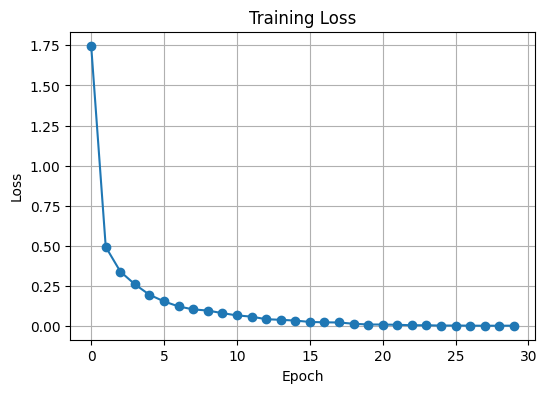

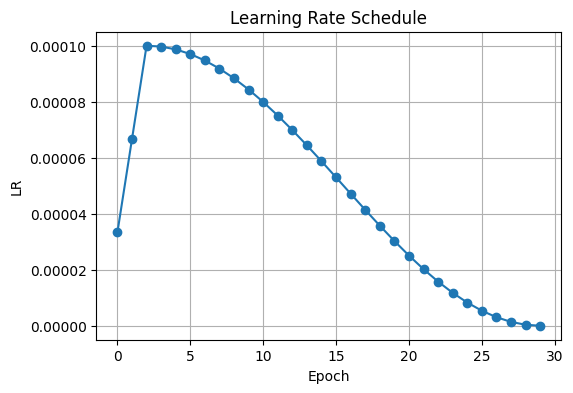

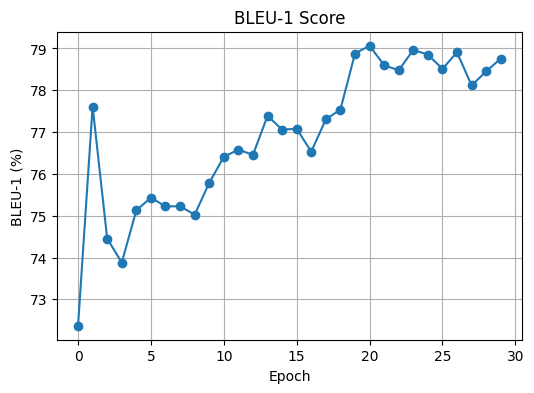

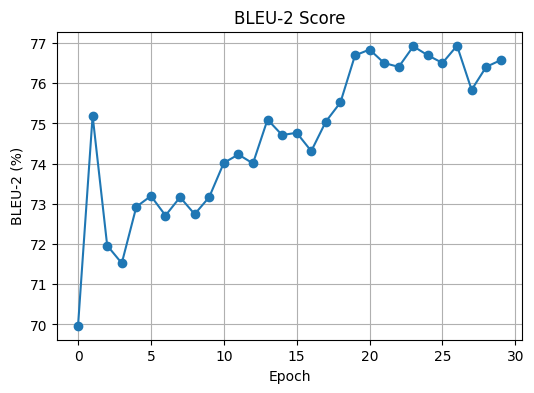

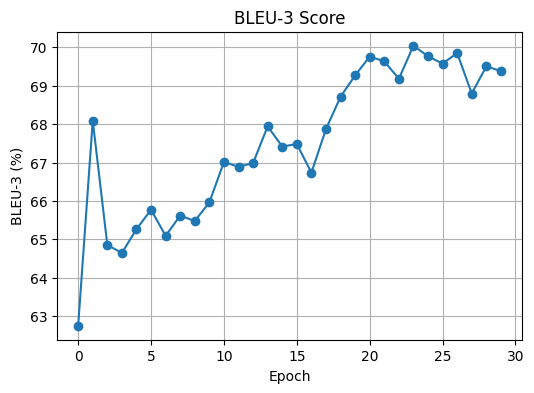

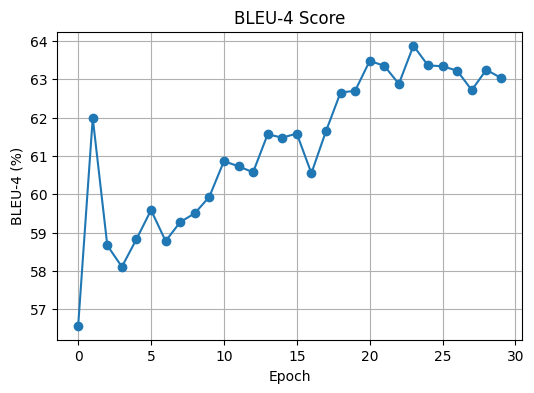

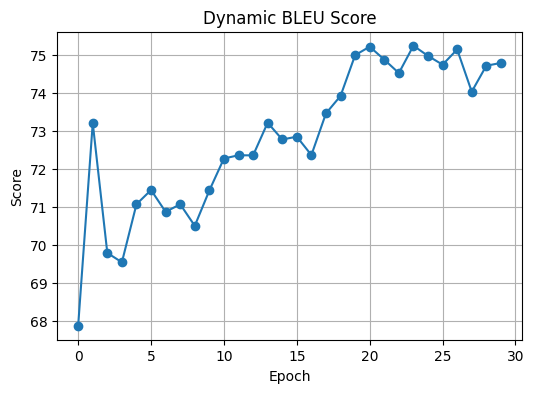

In [6]:
# ================== 结果可视化 ==================
import matplotlib.pyplot as plt

# 统一 epoch 横坐标
epochs = range(len(loss_history))

def plot_single_curve(values, title, ylabel, filename=None):
    plt.figure(figsize=(6, 4))
    plt.plot(epochs if len(values)==len(loss_history) else range(len(values)), values, marker='o')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    if filename:
        plt.savefig(filename)
    plt.show()

# 1. Train loss
plot_single_curve(loss_history, "Training Loss", "Loss", "loss_curve.png")

# 2. Learning rate（以step为横轴）
plot_single_curve(lr_history, "Learning Rate Schedule", "LR", "lr_curve.png")

# 3-6: BLEU curves
plot_single_curve(bleu1_history, "BLEU-1 Score", "BLEU-1 (%)", "bleu1.png")
plot_single_curve(bleu2_history, "BLEU-2 Score", "BLEU-2 (%)", "bleu2.png")
plot_single_curve(bleu3_history, "BLEU-3 Score", "BLEU-3 (%)", "bleu3.png")
plot_single_curve(bleu4_history, "BLEU-4 Score", "BLEU-4 (%)", "bleu4.png")

# 7: Dynamic score
plot_single_curve(dynamic_history, "Dynamic BLEU Score", "Score", "dynamic_score.png")


In [7]:
# ================== 最终测试 ==================
def generate_answer(context, question):
    input_text = f"question: {question} context: {context}"
    inputs = tokenizer(input_text, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            max_length=Config.max_target_length,
            num_beams=5
        )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [13]:
print("测试")
test_context = "4月10日星期四，中国人一觉醒来后发现，除了中国，特朗普几乎给全球各国都在90天的时间内减免了刚宣布实施的对等关税，只有中国被课以重税。星期四，白宫公布了总统关税令，对中国产品加征的关税总量高达145%！145%的附加关税就等同于，美国对中国产品实施了禁运。不过，中国没有屈服。法国世界报北京通讯员蒂博（Harold Thibault）周四写道，中美两国之间的贸易战正在进一步升级，中国虽然单枪匹马，但仍然不向特朗普低头。相关文章强调，中美两国之间的贸易战强化了中国的信念：这就是，美国的对华外交政策的唯一目的就是为了阻止中国的崛起。"
test_question = "特朗普对中国增加了多少的关税？"
print(f"问题: {test_question}")
print(f"回答: {generate_answer(test_context, test_question)}")

测试
问题: 特朗普对中国增加了多少的关税？
回答: 145%


In [11]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# 替换为你保存模型的实际路径
model_path = "./best_models/epoch_24_dynamic_75.24"  # 举例路径，根据你保存模型的实际路径填写

# 加载 tokenizer 和模型
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

# 放到设备上
model = model.to(device)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
# 你已经写好该函数，无需修改
test_context = "4月10日星期四，中国人一觉醒来后发现，除了中国，特朗普几乎给全球各国都在90天的时间内减免了刚宣布实施的对等关税，只有中国被课以重税。星期四，白宫公布了总统关税令，对中国产品加征的关税总量高达145%！145%的附加关税就等同于，美国对中国产品实施了禁运。不过，中国没有屈服。法国世界报北京通讯员蒂博（Harold Thibault）周四写道，中美两国之间的贸易战正在进一步升级，中国虽然单枪匹马，但仍然不向特朗普低头。相关文章强调，中美两国之间的贸易战强化了中国的信念：这就是，美国的对华外交政策的唯一目的就是为了阻止中国的崛起。"
test_question = "特朗普对中国增加了多少的关税？"

print(f"问题: {test_question}")
print(f"回答: {generate_answer(test_context, test_question)}")


问题: 特朗普对中国增加了多少的关税？
回答: 145%
